# 1 Setup

# 1.1 Read Packages

In [1]:
import pandas as pd
import numpy as np

from lightfm import LightFM
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm.cross_validation import random_train_test_split
from scipy import sparse, linalg

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

D:\Anaconda\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


# 1.2 Read Data

In [2]:
df_FR = pd.read_csv('UMW_FR_reduced.csv', usecols = ['source', 'country_name', 'mama_movie_id', 'original_title'])
df_IT = pd.read_csv('UMW_IT_reduced.csv', usecols = ['source', 'country_name', 'mama_movie_id', 'original_title'])
df_ES = pd.read_csv('UMW_ES_reduced.csv', usecols = ['source', 'country_name', 'mama_movie_id', 'original_title'])

# 2 Data Preprocessing

# 2.1 Build Matrix A and M
Here each platform is a row in A

In [3]:
#Drop na and concatenate all the tables together
dfs_list = []
for d in [df_FR, df_IT, df_ES]:
    d['source'] = d['source'] + '_' + d['country_name']
    temp = d[['source', 'mama_movie_id']].dropna()
    temp['mama_movie_id'] = temp['mama_movie_id'].astype(int)
    dfs_list.append(temp)

df = pd.concat(dfs_list, axis=0)

In [4]:
#Create the sparse matrix
df['count'] = 1
df = pd.pivot_table(df, values='count', index=['source'], columns=['mama_movie_id'], aggfunc=np.sum, fill_value=0)
A = sparse.coo_matrix(df.values)

In [5]:
#Get the map between mama ids and original titles
dfs_list = []
for d in [df_FR, df_IT, df_ES]:
    temp = d[['original_title', 'mama_movie_id']].dropna()
    temp['mama_movie_id'] = temp['mama_movie_id'].astype(int)
    dfs_list.append(temp)
id_to_title = pd.concat(dfs_list, axis=0)
id_to_title = id_to_title.set_index('mama_movie_id').to_dict()['original_title']

In [16]:
df

mama_movie_id,1,3,5,7,8,9,10,11,12,14,...,43790,43791,43792,43793,43829,43831,43850,43851,44007,44009
source,,,,,,,,,,,,,,,,,,,,,
arte_France,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
canal vod_France,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
filmin_Spain,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
google_France,0,330,0,388,0,0,41,0,0,0,...,0,0,0,0,0,4,0,0,0,0
google_Italy,0,0,0,0,0,0,0,0,0,0,...,72,373,137,11,0,0,0,0,0,9
google_Spain,0,0,0,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
itunes_France,953,1500,766,1448,1759,421,1198,24,178,33,...,0,0,0,0,11,7,0,0,0,0
itunes_Italy,0,0,0,0,0,0,0,140,737,0,...,100,594,370,1,0,0,0,0,14,77
itunes_Spain,0,0,0,479,0,212,0,0,0,0,...,0,0,0,0,0,0,174,41,0,0


# 2.2 Facts About A

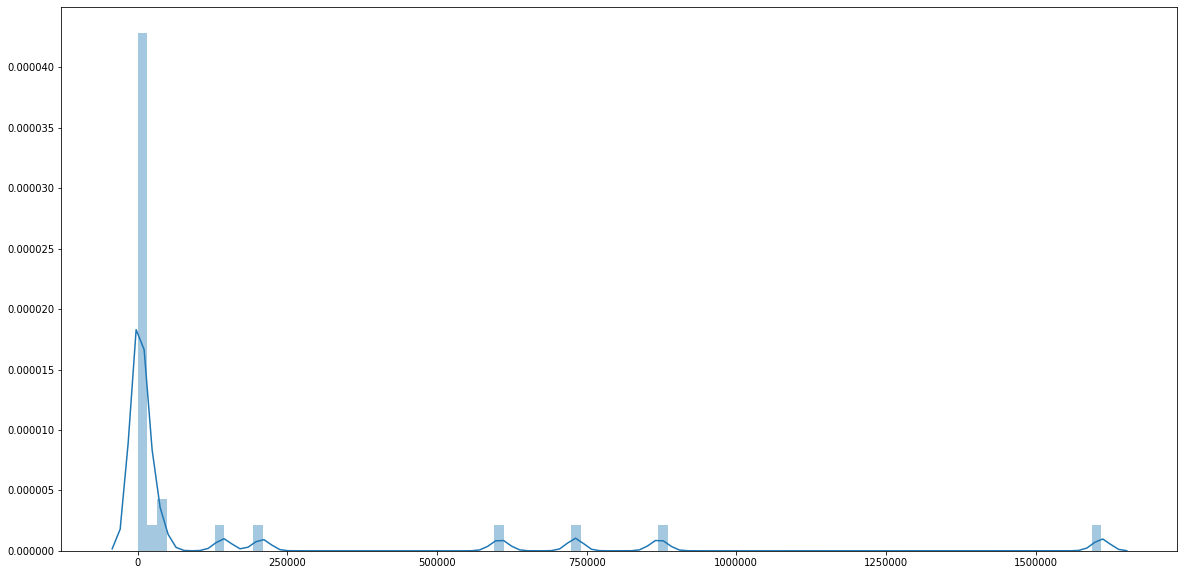

In [151]:
data = np.sum(A, axis=1)
fig, ax = plt.subplots(ncols=1, figsize=[20,10])

#The distribution of the number of movies watched by each user
g = sns.distplot(data, bins=100, ax=ax)

# 3 Collabrative Filtering

# 3.1 Modeling

In [6]:
model = LightFM(loss='warp', no_components=5, k=5)

# 3.2 Cross Validation

In [154]:
train, test = random_train_test_split(A, test_percentage=0.3)

In [155]:
model.fit(train, epochs=3000, num_threads=8)

In [156]:
train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test).mean()
print('train_auc: ', train_auc)
print('test_auc: ', test_auc)

train_auc:  0.9984471
test_auc:  0.7404461


In [157]:
#Precision measures, if you select k movies for each customer in the test set, 
#the number of correctedly identified movies / k

train_precision = precision_at_k(model, train, k=5).mean()
test_precision = precision_at_k(model, test, k=5).mean()
print('train_precision: ', train_precision)
print('test_precision: ', test_precision)

train_precision:  0.63571435
test_precision:  0.016


In [158]:
#Recall measures, if you select k movies for each customer in the test set, 
#the number of correctedly identified movies / the number of movies that a customer has watched

train_recall = recall_at_k(model, train, k=5).mean()
test_recall = recall_at_k(model, test, k=5).mean()
print('train_recall: ', train_recall)
print('test_recall: ', test_recall)

train_recall:  0.15246827824235737
test_recall:  0.04181818181818182


# 3.3 Model Training

In [7]:
model.fit(A, epochs=3000, num_threads=8)

# 3.4 Customer Vectors and Movie Vectors

In [8]:
C_b, C = model.get_user_representations()
M_b, M = model.get_item_representations()

# 3.5 Predictions

In [72]:
def recommendation(model, data, top_n=5):
    n_users, n_items = data.shape
    temp = np.zeros([n_users, top_n])
    for i in np.arange(n_users):
        existing = data.iloc[i, :] # Exisitng movies in that platform
        existing = (existing[existing>0]).index

        scores = model.predict(i, np.arange(n_items))
        ranking = data.columns[np.argsort(-scores)] # The predicted rankings of movies for a particular platform

        ranking_filtered = [item for item in ranking if item not in existing] # Filter out the existing movies

        top_items = ranking_filtered[:top_n]
        temp[i,:] = top_items
    
    temp = pd.DataFrame(temp, dtype=int)
    temp.columns = ['Top_' + str(c+1) for c in temp.columns]
    temp = temp.replace(id_to_title)

    result = pd.DataFrame({'source_country': df.index})
    result = pd.concat([result, temp], axis = 1)
    
    return result

In [73]:
recommendation(model, df, top_n=5)

,source_country,Top_1,Top_2,Top_3,Top_4,Top_5
0,arte_France,Ferrari 312B: Where the revolution begins,Mala Mala,The Escort,Dead In 5 Heartbeats,That Awkward Moment
1,canal vod_France,Un Bacio,Star,Almost Friends,Mala Mala,Gurov & Anna
2,filmin_Spain,Beneath The Harvest Sky,Mala Mala,Nullpunkt,Wa-shoku: Beyond Sushi,Marcus
3,google_France,La Fuga: Girl in Flight,Galore,In My Mother's Arms,Spijt!,Paradise! Paradise!
4,google_Italy,Knucklehead,Legendary,Dirty Wars (VOST),Frog Kingdom,Und in der Mitte der Erde war Feuer
5,google_Spain,WiNWiN,Fair Play (2014),Min lilla syster,Hjartasteinn,The Sheltering Sky
6,itunes_France,Bling,The paranormal diaries : Clophill,Galore,The Misandrists,Democracy: Im Rausch der Daten
7,itunes_Italy,Galore,Fair Play (2014),Las Vacas Con Gafas,Les châteaux de sable,Försvunnen
8,itunes_Spain,Galore,Und in der Mitte der Erde war Feuer,Fill de Caín (VOST),CREATION (VOST),The Haumana
9,microsoft_France,Prank,Galore,All the Wrong Reasons,The paranormal diaries : Clophill,While They Watched
